In [1]:
import torch
import torchvision
from torchvision import transforms as tvt
from PIL import Image
from PIL import ImageOps
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.nn import parallel


In [2]:
dir_root = (os.getcwd() + '/')

None (256, 256) RGB
None (256, 256) RGB
(256, 256)


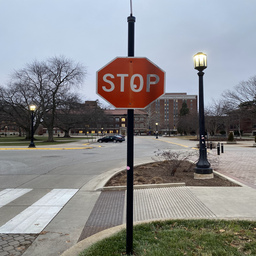

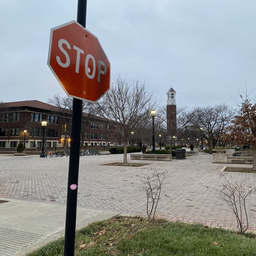

In [3]:
#open image with PIL library:
im_straight = Image.open(dir_root + "stopsign_straight.jpg") ## name of image file
im_oblique_left = Image.open(dir_root + "stopsign_oblique_left.jpg") ## name of image 

im_straight = im_straight.resize((256, 256), Image.ANTIALIAS)
im_oblique_left = im_oblique_left.resize((256, 256), Image.ANTIALIAS)
#im_oblique_right = Image.open(dir_root + "stopsign_oblique_right.jpg") ## name of image file

img_list_PIL = [im_straight,im_oblique_left]

print(im_straight.format, im_straight.size, im_straight.mode)
print(im_oblique_left.format, im_oblique_left.size, im_oblique_left.mode) #same size as straight! cool. 
print(im_oblique_left.size)


display(im_straight)
display(im_oblique_left)

Now, we need to convert the PIL image to a torch tensor

In [268]:
transform = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0], [1])])
transform_to_tensor = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0], [1])])
affine = tvt.Compose([tvt.RandomAffine([-35, 35])])

img_list_tensor_at = [] #at = after transform
for n, i in enumerate(img_list_PIL):
    img_list_tensor_at.append(transform(i)) #transform PIL image to tensor, normalize it, apply randomAffine transform
    #print(type(img_list_tensor_at[n]))
    #img_list_tensor_at[n] = tvt.functional.perspective(i, startpoints = ([500, 900], [500, 1500], [1500, 1500], [1500, 900]), endpoints = ([300,300], [600, 900], [1100, 1000], [1000, 500]) ) 
    #line above performs functional perspective transform
    print(type(img_list_tensor_at[n]))
    if (n == 0): #input image is straight stop sign, target is oblique stop sign
        #img_list_tensor_at[n] = tvt.functional.perspective(img_list_tensor_at[n], startpoints = ([75-5,110-5], [75-5,140+5], [90+5,140+5], [90+5,110-5]), 
         #                                                  endpoints = ([40-5,50-5], [60-5,100+5], [80+5,95+5], [60+5,45-5]))
        img_list_tensor_at[n] = tvt.functional.perspective(img_list_tensor_at[n], startpoints = ([48, 80], [51, 208], [176,208], [176,64]),
                                                           endpoints = ([16, 16], [16, 128], [208, 208], [208, 112]))
    if (n == 1): #input image is oblique stop sign, target is straight stop sign. 
        #we need to switch the start and endpoints. 
        #img_list_tensor_at[n] = tvt.functional.perspective(img_list_tensor_at[n], endpoints = ([75-5,110-5], [75-5,140+5], [90+5,140+5], [90+5,110-5]), 
         #                                                  startpoints = ([40-5,50-5], [60-5,100+5], [80+5,95+5], [60+5,45-5]))
        img_list_tensor_at[n] = tvt.functional.perspective(img_list_tensor_at[n], endpoints = ([16, 16], [16, 128], [208, 208], [208, 112]), 
                                                           startpoints = ([48, 80], [51, 208], [176,208], [176,64]))
    #img_list_tensor_at[n] = transform_to_tensor(img_list_tensor_at[n]) #converts back to Tensor


<class 'torch.Tensor'>
<class 'torch.Tensor'>


The code below is to convert my original images to numpy via the transformations (but not the affine or perspective transforms). The numpy representations are to print the images using matplotlib

In [269]:
img_list_np_bt = [] #create tensor and then numpy representations before the affine and perspective transforms to print those images out.
for n, i in enumerate(img_list_PIL):
    img_list_np_bt.append(transform_to_tensor(i)) #apply 0-1 conversion and then normalization. Currently, a tensor. 
    img_list_np_bt[n] = np.transpose(np.array(img_list_np_bt[n]), (1, 2, 0)) #create a numpy format for printing image in matplotlib

Print transformed images. For this, we need to have data in a numpy array. Numpy representation is H, W, C, while the torch tensor is C, H, W. The images that went through the affine and perspective transforms have NOT yet been converted to numpy. That is now done below.

In [270]:
img_list_np_at = []
for i in img_list_tensor_at:
    img_list_np_at.append(np.transpose(np.array(i), (1, 2, 0)))

Create a figure with 4 subplots. The top row is the data before the affine and perspective transformations and the bottom row is the data after the affine and perspective transformation. 

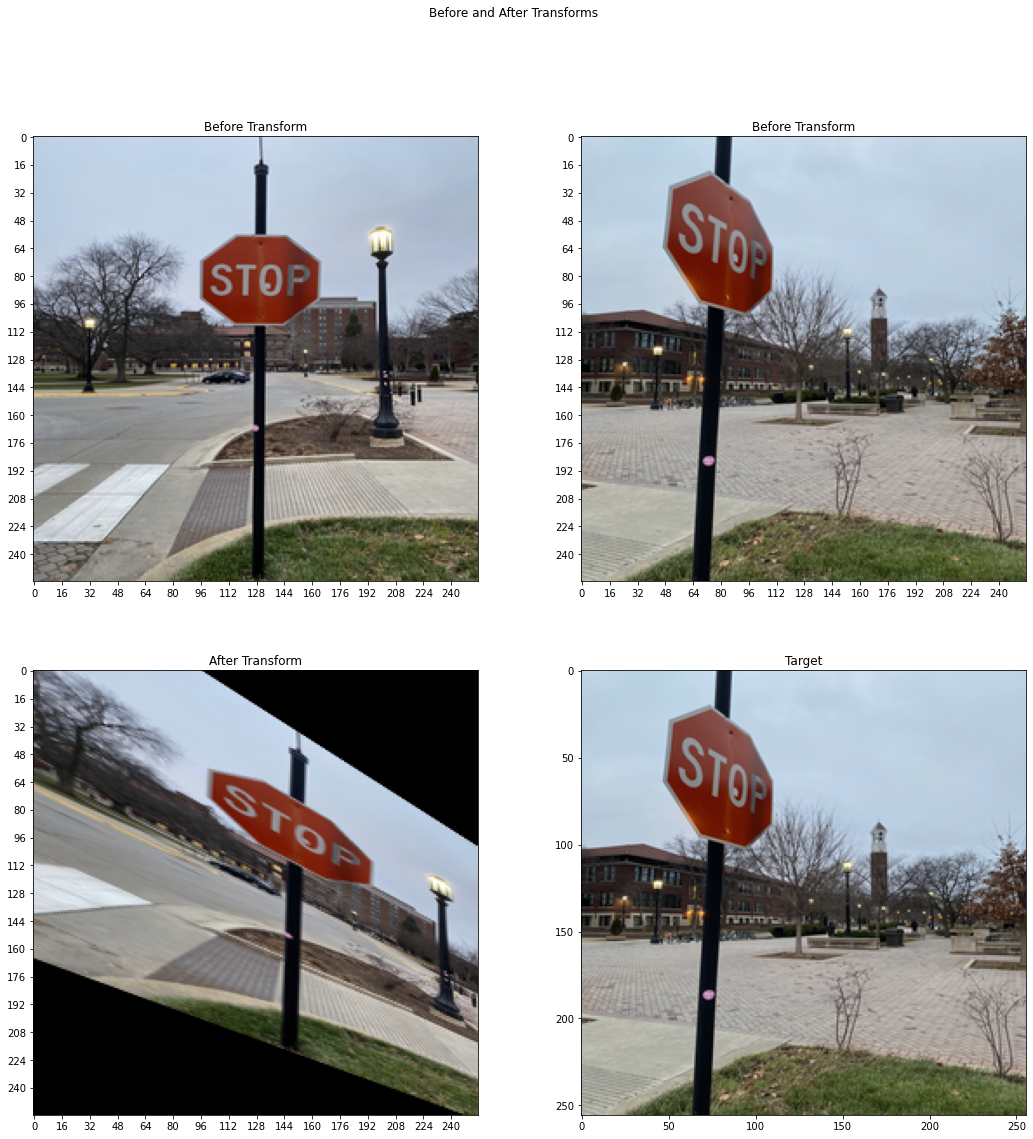

In [271]:
fig, ax = plt.subplots(2,len(img_list_tensor_at))
fig.set_size_inches(18,18)
ticks = np.linspace(0, 256, num=16, endpoint=False)

fig.suptitle('Before and After Transforms')
for n, i in enumerate(range(len(img_list_np_bt))):
    ax[0,n].imshow(img_list_np_bt[i])
    ax[0,n].set_title('Before Transform')
    ax[0, n].set_xticks(ticks)
    ax[0, n].set_yticks(ticks)


for n, i in enumerate(img_list_tensor_at):
    temp = np.transpose(np.array(img_list_tensor_at[n]), (1, 2, 0))
    if (n == 0):
        ax[1, n].imshow(temp)
        ax[1, n].set_title('After Transform')
        ax[1, n].set_xticks(ticks)
        ax[1, n].set_yticks(ticks)
    if (n == 1):
        ax[1, n].imshow(img_list_np_bt[n])
        ax[1, n].set_title('Target')


Compute the Wasserstein Distance between 2 images before and after they have been transformed. Steps:
1) Compute histograms for each image (100 bins)

2) Compute wasserstein distance between them

In [267]:
from torch.nn.modules import distance
from scipy.stats import wasserstein_distance


li_hist_after_transform = []
#the loop below is wasserstein distance after the transformation
for n, i in enumerate(img_list_tensor_at):
    if (n == 0):
        hist1 = torch.histc(i, bins = 100)
        hist1 = hist1.div(hist1.sum())
        li_hist_after_transform.append(hist1)
    if (n == 1):
        hist2 = torch.histc(i, bins = 100)
        hist2 = hist2.div(hist2.sum())
        li_hist_after_transform.append(hist2)


dist_after_transform = wasserstein_distance( hist1, hist2)
print('distance between transformed images:', dist_after_transform)

#the loop below is wassersten distance before the transformation
li_hist_before_transform = []

for n, i in enumerate(img_list_np_bt):
  #convert numpy to torch tensor
    temp = torch.from_numpy(i)
    if (n == 0):
        hist1 = torch.histc(temp, bins = 100)
        hist1 = hist1.div(hist1.sum())
        li_hist_before_transform.append(hist1)
    if (n == 1):
        hist2 = torch.histc(temp, bins = 100)
        hist2 = hist2.div(hist2.sum())
        li_hist_before_transform.append(hist2)

dist_before_transform = wasserstein_distance( li_hist_before_transform[0], li_hist_before_transform[1] )
print('distance between non-transformed images: ', dist_before_transform)

dist_btwn_transform_and_target =  wasserstein_distance(li_hist_before_transform[1], li_hist_after_transform[0])

print('distance between best transformed and target:' ,dist_btwn_transform_and_target )


distance between transformed images: 0.001492614757835327
distance between non-transformed images:  0.0014100138124922524
distance between best transformed and target: 0.005413309821669828


3.3 Creating your own Dataset class that is based on torch.utils.data.Dataset

In [27]:
root = '10_HW2_photos/'
import random
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        super(MyDataset).__init__()
        self.root = (dir_root + root)
        self.filenames = []
        for filename in os.listdir(self.root):
            self.filenames.append(filename)
        self.augmentation = tvt.Compose([tvt.ToTensor(), tvt.Resize((256,256)), 
                                        tvt.Normalize([0], [1]) , 
                                        tvt.ColorJitter(0.75, 0.75) , 
                                        tvt.RandomHorizontalFlip( p = 0.75), 
                                        tvt.RandomRotation(degrees = 45) ])
        self.resize = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0], [1]), tvt.Resize((256, 256))])
  
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        item = Image.open(self.root + self.filenames[index])
        print(self.root + self.filenames[index])
        aug_img = self.augmentation(item)
        class_label = random.randint(0,10)
        return aug_img, class_label
  
    def convertOriginal_to_np(self, num_images_to_display):
        count = 0
        orig = []
        for img in self.filenames:
            full_img_file_path = self.root + img
            img_tensor = self.resize(Image.open(full_img_file_path))
            img_np = np.transpose(np.array(img_tensor), (1, 2, 0))
            orig.append(img_np)
            if count >= num_images_to_display - 1:
                break
            else:
                count = count + 1
        return orig

my_dataset = MyDataset(root)
print(len(my_dataset))
index = 2
print(my_dataset[index][0].shape, my_dataset[index][1])


10
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7231.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7231.jpg
torch.Size([3, 256, 256]) 0


Plot input input images and output images of the transform for 3 images in dataset of MyDataset. This is a 2 x 3 plot

/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7223.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7222.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7231.jpg


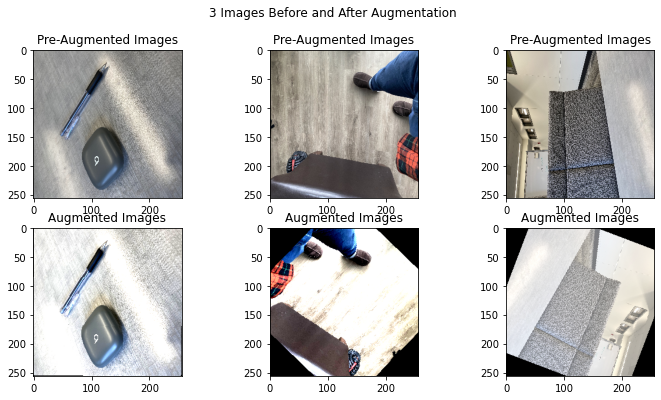

In [28]:
img1 = MyDataset(root)
li_pre_transform_imgs = img1.convertOriginal_to_np(3)

fig, ax = plt.subplots(2,3)
fig.set_size_inches(12,6)

fig.suptitle('3 Images Before and After Augmentation')

for n in range(3):
    if (n < 3):
        ax[1, n].imshow(np.transpose(np.array(img1[n][0]), (1, 2, 0)))
        ax[1, n].set_title('Augmented Images')

for n, i in enumerate(li_pre_transform_imgs):
    
    ax[0, n].imshow(i)
    ax[0, n].set_title('Pre-Augmented Images')

Generating Data in Parallel. We now will build a dataloader class that will yield a *batch* of training samples. First, wrap an instance of the customer dataset class within torch.utils.data.DataLoader class. Plot 4 images (i.e, one batch). italicized

/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7223.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7232.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7227.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7222.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7229.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7231.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7225.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7228.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7230.jpg
/Users/alim/Documents/ECE60146/hw2/10_HW2_photos/IMG_7226.jpg


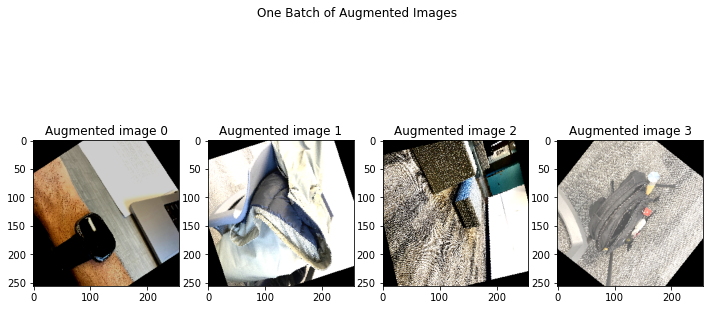

In [33]:
my_dataloader = torch.utils.data.DataLoader(img1, batch_size=6, num_workers=2, drop_last=False)
fig, ax = plt.subplots(1,4)
fig.set_size_inches(12,6)
fig.suptitle("One Batch of Augmented Images")
for batch in my_dataloader:
    #Note: each batch is a list of length 2. The first is a pytorch tensor B x C x H x W and the 
    #second is a pytorch tensor of length B with the associated class labels of each image in the 
    #first item of the list!
    count = 0
    while (count == 0):
        for i in range(4):
            ax[i].imshow(np.transpose(np.array(batch[0][i]), (1, 2, 0)))
            ax[i].set_title('Augmented image ' + str(i))
        count += 1
  




Compare and discuss performance gain by using multi-threaded DataLoader vs just using Dataset.

Record time needed to load and augment 1000 random images in dataset by calling my_dataset._getitem_ 1000 times.
Record time needed by my_dataloader to process 1000 random images

In [99]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        #print('in init for ', root)
        super(MyDataset).__init__()
        self.root = (dir_root + root)
        self.filenames = []
        for filename in os.listdir(self.root):
            self.filenames.append(filename)
        self.augmentation = tvt.Compose([tvt.ToTensor(), tvt.Resize((256,256)), 
                                        tvt.Normalize([0], [1]) , 
                                        tvt.ColorJitter(0.75, 0.75) , 
                                        tvt.RandomHorizontalFlip( p = 0.75), 
                                        tvt.RandomRotation(degrees = 45) ])
        self.resize = tvt.Compose([tvt.ToTensor(), tvt.Normalize([0], [1]), tvt.Resize((256, 256))])
  
    def __len__(self):
        return 1000

    def __getitem__(self, index):
        index = index % 10
        item = Image.open(self.root + self.filenames[index])
        #print('index is', index)
        aug_img = self.augmentation(item)
        class_label = random.randint(0,10)
        return aug_img, class_label

In [106]:
import time
seed = 0
random.seed(seed)
##### START MEASURING TIME FOR my_dataset ########   
start_time = time.time()
for i in range(1000):
    my_dataset.__getitem__(index = random.randint(0,9))
    if (i % 100 == 0):
        end_time = time.time()
print("Total time for fetching 1000 images without a dataloader was", end_time - start_time, " seconds")
##### END MEASURING TIME FOR my_dataset


Total time for fetching 1000 images without a dataloader was 109.49566292762756  seconds


In [100]:
batch_steps = [4, 8, 10]
num_worker_steps = [2, 4, 6]
results = np.zeros((3,3))
img1_test = MyDataset(root)
#print(results)
num_items = 1000
for m, i in enumerate(batch_steps):
    for n, j in enumerate(num_worker_steps):
        print("num_workers is", j, "and batch_size is", i)
        my_dataloader_test = torch.utils.data.DataLoader(img1_test, batch_size = i, num_workers = j)
        ##### START MEASURING TIME FOR my_dataloader ######
        start_time = time.time()
        count = 0
        batch_size = i
        for batch in my_dataloader_test:
            #print('in for loop with ', i, 'as ' , i, 'and j as', j)
            count+=1
            #print(count)
            if count >= (num_items/batch_size):
                end_time = time.time()
        ##### END MEASURING TIME FOR my_dataloader ######
                results[m][n] = (end_time - start_time)
                print("With batch size", batch_size, "and num_workers", j,  "loading", num_items,
                      "images took", results[m][n], "seconds")


print("Table of total time to load images. Each row is batch_size and each column is num_workers")
print("The best performance was ", results.min(), "seconds")
print(results)

num_workers is 2 and batch_size is 4
With batch size 4 and num_workers 2 loading 1000 images took 64.17058491706848 seconds
num_workers is 4 and batch_size is 4
With batch size 4 and num_workers 4 loading 1000 images took 33.857059955596924 seconds
num_workers is 6 and batch_size is 4
With batch size 4 and num_workers 6 loading 1000 images took 23.888015747070312 seconds
num_workers is 2 and batch_size is 8
With batch size 8 and num_workers 2 loading 1000 images took 65.36338877677917 seconds
num_workers is 4 and batch_size is 8
With batch size 8 and num_workers 4 loading 1000 images took 34.512320041656494 seconds
num_workers is 6 and batch_size is 8
With batch size 8 and num_workers 6 loading 1000 images took 24.143294095993042 seconds
num_workers is 2 and batch_size is 10
With batch size 10 and num_workers 2 loading 1000 images took 65.3996102809906 seconds
num_workers is 4 and batch_size is 10
With batch size 10 and num_workers 4 loading 1000 images took 33.93644595146179 seconds
n